# Setup

In [254]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from wordcloud import WordCloud
from tqdm import tqdm
import itertools

import nltk

from nltk.corpus import stopwords
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import re
import en_core_web_sm
nlp = en_core_web_sm.load()

from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

from textblob import TextBlob

plt.style.use('ggplot')

stop_words = set(stopwords.words('english'))
punctuation = list(punctuation)
lemmatizer = WordNetLemmatizer()

sia = SentimentIntensityAnalyzer()

from nrclex import NRCLex

## Read in the data

In [31]:
# Read in Data
df = pd.read_csv('data/cleanedData_Reviews.csv');
df = df[df['Year of Review'] != 2023];
df = df.reset_index(drop=True);
df.head(1)

,Reviewer Name,Reviewer Title,Total Reviews Given,Review,Stars Given,Year of Review,Time of Review,Webscraping Datetime
0,Alex Reyes,No Title,2,No Review,3,2022,a month ago,2023-01-29 20:55:10


## NLP Pre-Processing

In [32]:
# Pre-process reviews for natural language processing
def process_review_for_NLP(df, column, new_column):
    data = [];
    for i in tqdm(df.index, total=len(df)):
        review_tokens = word_tokenize(df.loc[i, column].lower());
        review_tokens_cleaned = [];
        for token in review_tokens:
            token = lemmatizer.lemmatize(token, pos="a");
            if (token not in stop_words) and (token not in punctuation):
                token = re.sub(r'[^\w\s]', '', token);
                if token != '':
                    # if str(nlp(token)[0].pos_) not in ["PNP","PNQ","PNX","POS","AVQ","CJC","CJS","CJT","DTQ","ITJ","PRF","PRP"]:
                    if str(nlp(token)[0].pos_) in ["ADJ","VERB","NOUN","ADV"]:
                        review_tokens_cleaned.append(token);
        review_cleaned = "";
        for token in review_tokens_cleaned:
            review_cleaned += token + " ";
        review_cleaned = review_cleaned.strip();
        data.append([review_cleaned]);
    cleaned_reviews = pd.DataFrame(data, columns=[new_column]);
    df_with_cleaned_reviews = pd.concat([df,cleaned_reviews], axis=1);
    return df_with_cleaned_reviews;

df = process_review_for_NLP(df, "Review", "Review Cleaned");
df.head()

  0%|          | 0/324 [00:00<?, ?it/s]

,Reviewer Name,Reviewer Title,Total Reviews Given,Review,Stars Given,Year of Review,Time of Review,Webscraping Datetime,Review Cleaned
0,Alex Reyes,No Title,2,No Review,3,2022,a month ago,2023-01-29 20:55:10,review
1,Hugo Nakamura,Local Guide,25,"EDIT: The second time coming to the store, the...",5,2022,a month ago,2023-01-29 20:55:10,edit second time coming store employee kind he...
2,Connor Gyori,No Title,4,I will never be shopping at this location agai...,1,2022,2 months ago,2023-01-29 20:55:10,never shopping location staff member male extr...
3,Abdo AK,No Title,1,Horrible staff will still come back for the gr...,2,2022,2 months ago,2023-01-29 20:55:10,horrible staff still come back great coffee un...
4,Daisy,No Title,18,(Translated by Google) I would rather shop onl...,3,2022,2 months ago,2023-01-29 20:55:10,translated rather shop online queue sell capsu...


## WordCloud
> Reference: [Sentiment Analysis with TextBlob
](https://www.youtube.com/watch?v=4GF-Knz9B10&list=LL&index=1)

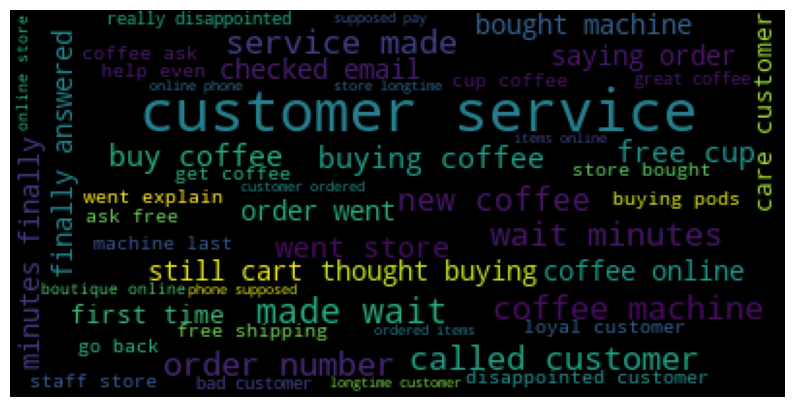

In [33]:
def plot_wordcloud(df, column, invalid_words, max_words):
    words = [];
    for i in df.index:
        for word in invalid_words:
            for review_word in df.loc[i, column].split(" "):
                if word != review_word:
                    words.append(df.loc[i, column]);
    cloud = WordCloud(max_words=max_words, stopwords=stop_words).generate(str(words));
    plt.figure(figsize=(10,10));
    plt.axis('off');
    plt.grid(visible=None);
    plt.imshow(cloud)

# Most frequently used words by reviewers regarding Nespresso
plot_wordcloud(
    df=df, 
    column="Review Cleaned",
    invalid_words=["Review","No Review","Nespresso","Review'","review'"],
    max_words=50
)

# VADER Sentiment Scoring
> Reference: [Python Sentiment Analysis Project with NLTK and 🤗 Transformers. Classify Amazon Reviews!!](https://www.youtube.com/watch?v=QpzMWQvxXWk&list=LL&index=1)

**Sentiment Analysis in Python**  
In this section of the notebook, we will be doing some sentiment analysis in Python using the VADER technique:
* VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of Words Approach

We will use NLTK `SentimentIntensityAnalyzer` to get the neg/neu/pos scores of the text.

* The use of "bag of words" approach:
    1. Stop words are removed
    2. Each word is scored and combined to a total score

In [34]:
# Run the polarity score on the entire dataset
def get_polarityScore_Vader(df, column):
    data = [];
    for i in tqdm(df.index, total=len(df)):
        row = [];
        vader = sia.polarity_scores(df.loc[i, column]);
        for elem in ['neg','neu','pos','compound']:
            row.append(vader.get(elem));
        data.append(row);
    vaders = pd.DataFrame(data, columns=['Negative','Neutral','Positive','Compound']);
    df_with_vaders = pd.concat([df,vaders], axis=1)
    return df_with_vaders;

# df_with_vaders = get_polarityScore_Vader(df, "Review");
df_with_vaders = get_polarityScore_Vader(df, "Review Cleaned");

# Now we have sentiment score and metadata
df_with_vaders.head(1)

  0%|          | 0/324 [00:00<?, ?it/s]

,Reviewer Name,Reviewer Title,Total Reviews Given,Review,Stars Given,Year of Review,Time of Review,Webscraping Datetime,Review Cleaned,Negative,Neutral,Positive,Compound
0,Alex Reyes,No Title,2,No Review,3,2022,a month ago,2023-01-29 20:55:10,review,0.0,1.0,0.0,0.0


### Plot VADER results

<AxesSubplot:title={'center':'Compound Score by Nespresso Google Star Review'}, xlabel='Stars Given', ylabel='Compound'>

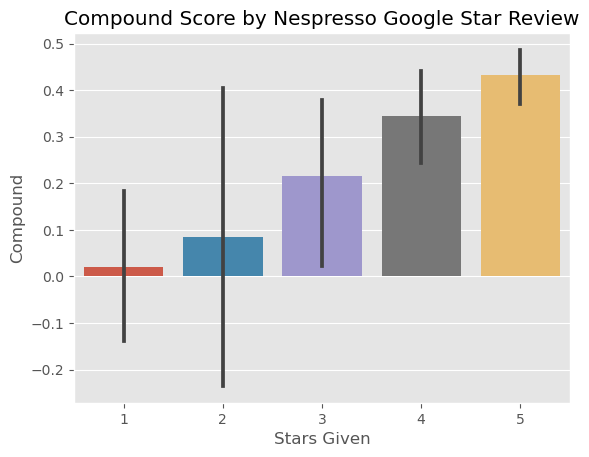

In [35]:
def plot_vaderResults(df, x, y, title):
    ax = sns.barplot(data=df, x=x, y=y);
    ax.set_title(title);
    return ax;

plot_vaderResults(
    df=df_with_vaders, 
    x="Stars Given", 
    y="Compound", 
    title="Compound Score by Nespresso Google Star Review"
)

array([<AxesSubplot:title={'center':'Negative'}, xlabel='Stars Given', ylabel='Negative'>,
       <AxesSubplot:title={'center':'Neutral'}, xlabel='Stars Given', ylabel='Neutral'>,
       <AxesSubplot:title={'center':'Positive'}, xlabel='Stars Given', ylabel='Positive'>],
      dtype=object)

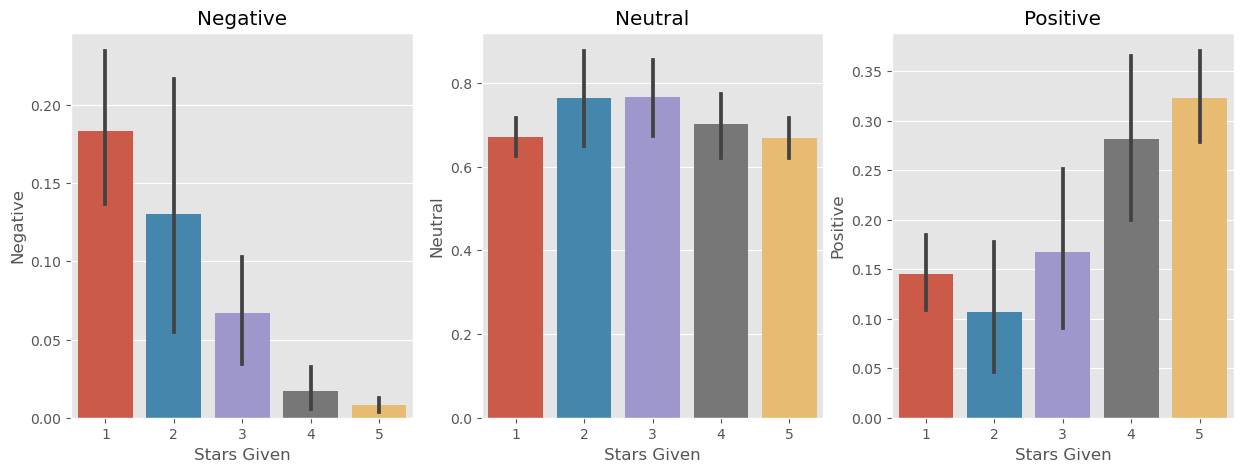

In [36]:
def plot_vaderResults_byType(df, row, col , x, y):
    fig, ax = plt.subplots(row, col, figsize=(15,5));
    for i in range(col):
        sns.barplot(data=df, x=x, y=y[i], ax=ax[i]);
        ax[i].set_title(y[i]);
    return ax;

plot_vaderResults_byType(
    df=df_with_vaders,
    row=1,
    col=3,
    x="Stars Given", 
    y=['Negative','Neutral','Positive']
)

/var/folders/6l/mm7mjc7502v12t9w6jsrkdcr0000gn/T/ipykernel_20179/883415791.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=xticklabels, title=title);


<AxesSubplot:title={'center':'Sentiment Score over the years by Sentiment Classification'}, xlabel='Year', ylabel='Sentiment Score'>

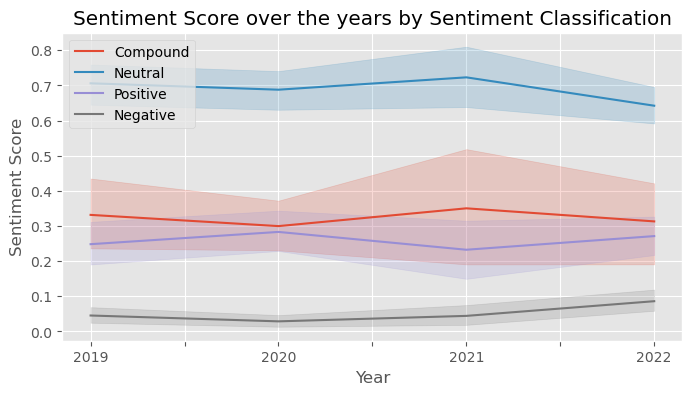

In [37]:
def plot_vaderResults_byYear(df, year, sentiment, title, xticklabels):
    data = [];
    for i in df.index:
        for elem in sentiment:
            row = [];
            row.append(df.loc[i, year]);
            row.append(elem);
            row.append(df.loc[i, elem]);
            data.append(row);
    df_vaders_year = pd.DataFrame(data, columns=["Year","Sentiment","Sentiment Score"]);
    df_vaders_year = df_vaders_year.sort_values(by="Year", ascending=True);
    
    fig, ax = plt.subplots(figsize=(8,4));
    ax = sns.lineplot(data=df_vaders_year, x="Year", y="Sentiment Score", hue="Sentiment");
    ax.set(xticklabels=xticklabels, title=title);
    ax.legend(loc="upper left");
    return ax;


plot_vaderResults_byYear(
    df=df_with_vaders,
    year="Year of Review",
    sentiment=["Negative","Neutral","Positive","Compound"],
    xticklabels=['','2019','','2020','','2021','','2022'],
    title="Sentiment Score over the years by Sentiment Classification",
)

<AxesSubplot:title={'center':'Compound Score by Nespresso Google Reviewer Title'}, xlabel='Reviewer Title', ylabel='Compound'>

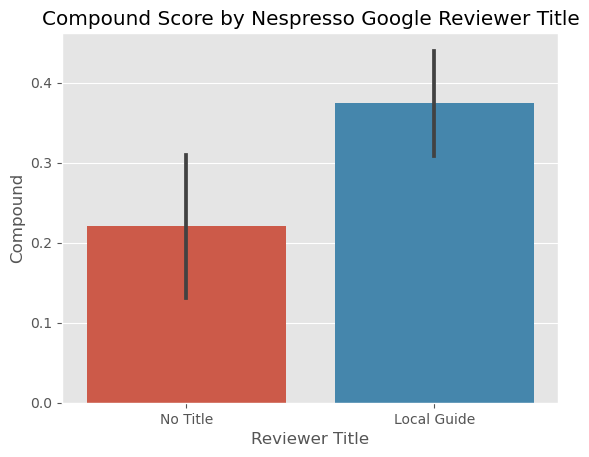

In [173]:
plot_vaderResults(
    df=df_with_vaders, 
    x="Reviewer Title", 
    y="Compound", 
    title="Compound Score by Nespresso Google Reviewer Title"
)

array([<AxesSubplot:title={'center':'Negative'}, xlabel='Reviewer Title', ylabel='Negative'>,
       <AxesSubplot:title={'center':'Neutral'}, xlabel='Reviewer Title', ylabel='Neutral'>,
       <AxesSubplot:title={'center':'Positive'}, xlabel='Reviewer Title', ylabel='Positive'>],
      dtype=object)

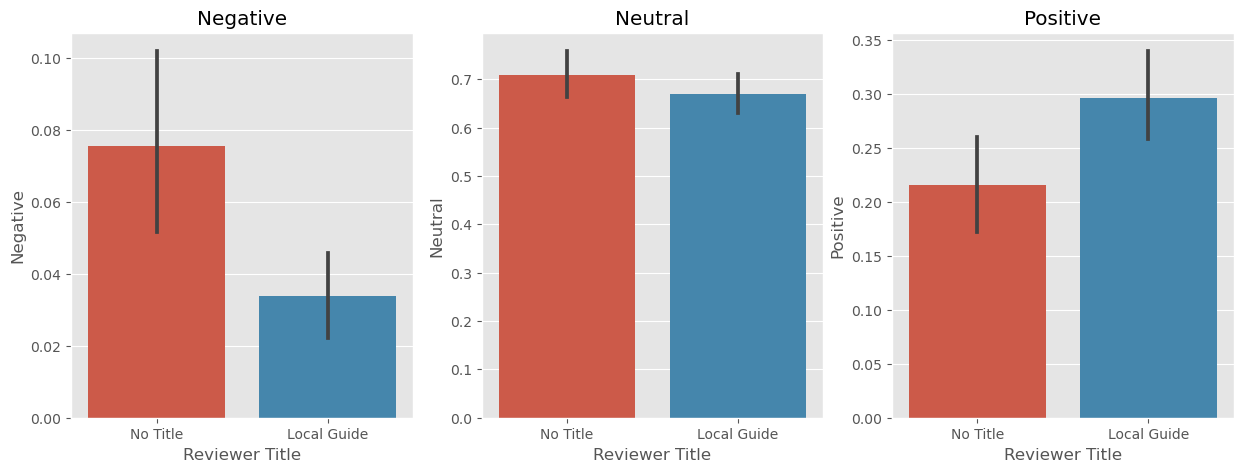

In [170]:
plot_vaderResults_byType(
    df=df_with_vaders,
    row=1,
    col=3,
    x="Reviewer Title", 
    y=['Negative','Neutral','Positive']
)

In [177]:
# Negative Sentiment Word Cloud
# plot_wordcloud(
#     df=df_with_vaders[df_with_vaders["Compound"] < 0], 
#     column="Review Cleaned",
#     invalid_words=["Review","No Review","Nespresso","Review'","review'"],
#     max_words=50
# )

In [178]:
# Positive Sentiment Word Cloud
# plot_wordcloud(
#     df=df_with_vaders[df_with_vaders["Compound"] > 0], 
#     column="Review Cleaned",
#     invalid_words=["Review","No Review","Nespresso","Review'","review'"],
#     max_words=50
# )

# Textblob Sentiment Scoring
> Reference: [A Quick Guide To Sentiment Analysis | Sentiment Analysis In Python Using Textblob | Edureka](https://www.youtube.com/watch?v=O_B7XLfx0ic)

Additional Resources:
* https://textblob.readthedocs.io/en/dev/install.html

In [40]:
# TextBlob test using Cleaned Review sample
TextBlob(df['Review Cleaned'][1]).sentiment

Sentiment(polarity=0.3666666666666667, subjectivity=0.6333333333333333)

In [41]:
def get_polarityScore_TextBlob(df, column):
    data = [];
    for i in tqdm(df.index, total=len(df)):
        row = [];
        sentiment = TextBlob(df.loc[i, column]);
        row.append(sentiment.sentiment.polarity);
        row.append(sentiment.sentiment.subjectivity);
        data.append(row);
    textblobs = pd.DataFrame(data, columns=["Polarity","Subjectivity"]);
    df_with_textblobs = pd.concat([df, textblobs], axis=1);
    return df_with_textblobs;

df_with_textblobs = get_polarityScore_TextBlob(df, "Review Cleaned");
df_with_textblobs.head(1)

  0%|          | 0/324 [00:00<?, ?it/s]

,Reviewer Name,Reviewer Title,Total Reviews Given,Review,Stars Given,Year of Review,Time of Review,Webscraping Datetime,Review Cleaned,Polarity,Subjectivity
0,Alex Reyes,No Title,2,No Review,3,2022,a month ago,2023-01-29 20:55:10,review,0.0,0.0


array([<AxesSubplot:title={'center':'Polarity'}, xlabel='Stars Given', ylabel='Polarity'>,
       <AxesSubplot:title={'center':'Subjectivity'}, xlabel='Stars Given', ylabel='Subjectivity'>],
      dtype=object)

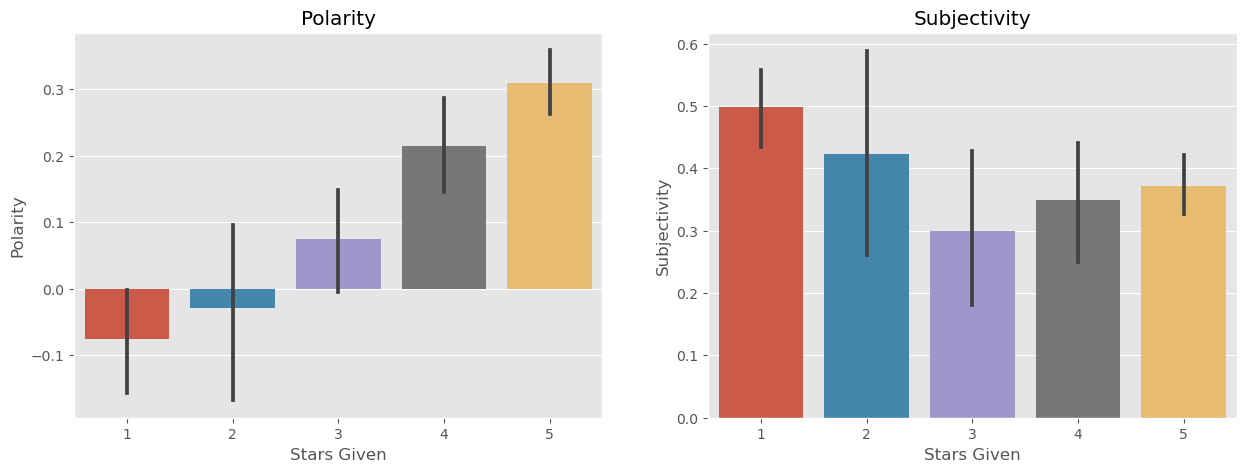

In [42]:
def plot_textblobResults_byType(df, row, col , x, y):
    fig, ax = plt.subplots(row, col, figsize=(15,5));
    for i in range(col):
        sns.barplot(data=df, x=x, y=y[i], ax=ax[i]);
        ax[i].set_title(y[i]);
    return ax;

plot_textblobResults_byType(
    df=df_with_textblobs,
    row=1,
    col=2,
    x="Stars Given", 
    y=['Polarity','Subjectivity']
)

array([<AxesSubplot:title={'center':'Polarity'}, xlabel='Reviewer Title', ylabel='Polarity'>,
       <AxesSubplot:title={'center':'Subjectivity'}, xlabel='Reviewer Title', ylabel='Subjectivity'>],
      dtype=object)

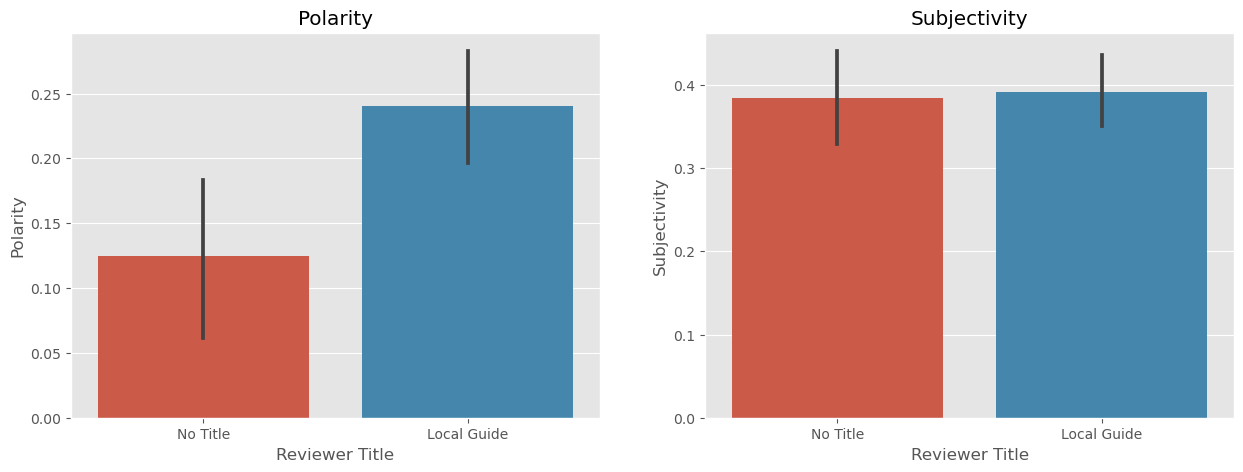

In [179]:
plot_textblobResults_byType(
    df=df_with_textblobs,
    row=1,
    col=2,
    x="Reviewer Title", 
    y=['Polarity','Subjectivity']
)

/var/folders/6l/mm7mjc7502v12t9w6jsrkdcr0000gn/T/ipykernel_20179/1861030528.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=xticklabels, title=title);


<AxesSubplot:title={'center':'Sentiment Score over the years by Sentiment & Subjectivity'}, xlabel='Year', ylabel='Sentiment Score'>

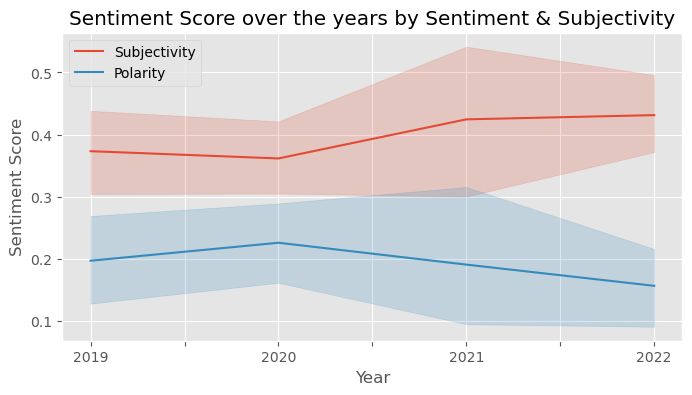

In [43]:
def plot_textblobResults_byYear(df, year, sentiment, title, xticklabels):
    data = [];
    for i in df.index:
        for elem in sentiment:
            row = [];
            row.append(df.loc[i, year]);
            row.append(elem);
            row.append(df.loc[i, elem]);
            data.append(row);
    df_vaders_year = pd.DataFrame(data, columns=["Year","Sentiment","Sentiment Score"]);
    df_vaders_year = df_vaders_year.sort_values(by="Year", ascending=True);
    
    fig, ax = plt.subplots(figsize=(8,4));
    ax = sns.lineplot(data=df_vaders_year, x="Year", y="Sentiment Score", hue="Sentiment");
    ax.set(xticklabels=xticklabels, title=title);
    ax.legend(loc="upper left");
    return ax;

plot_textblobResults_byYear(
    df=df_with_textblobs,
    year="Year of Review",
    sentiment=['Polarity','Subjectivity'],
    xticklabels=['','2019','','2020','','2021','','2022'],
    title="Sentiment Score over the years by Sentiment & Subjectivity",
)

In [176]:
# WordCloud based on Polarity score of less than 0
# plot_wordcloud(
#     df=df_with_textblobs[df_with_textblobs["Polarity"] < 0], 
#     column="Review Cleaned",
#     invalid_words=["Review","No Review","Nespresso","Review'","review'"],
#     max_words=50
# )

In [174]:
# WordCloud based on Polarity score of less than 0
# plot_wordcloud(
#     df=df_with_textblobs[df_with_textblobs["Polarity"] > 0], 
#     column="Review Cleaned",
#     invalid_words=["Review","No Review","Nespresso","Review'","review'"],
#     max_words=50
# )

# Emotion Classification using Lexicon based method
> Reference: [Simple Emotion Classification In Python
](https://medium.com/geekculture/simple-emotion-classification-in-python-40fb24692541)

Additional Resources:
* https://www.geeksforgeeks.org/emotion-classification-using-nrc-lexicon-in-python/
* https://stackoverflow.com/questions/45823078/how-to-sync-colors-across-subplots-of-different-types-seaborne-matplotlib
* https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8

In [139]:
def get_polarityScore_EmotionLex(df, column):
    data = [];
    for i in tqdm(df.index, total=len(df)):
        row = [];
        top_emotions = NRCLex(df.loc[i,'Review Cleaned']).top_emotions;
        emotions = [];
        for j in range(len(top_emotions)):
            emotions.append(top_emotions[j][0]);
        row.append(', '.join(emotions));
        row.append(top_emotions[0][1]);
        data.append(row);
    emotionLex = pd.DataFrame(data, columns=['Top Emotions','Affect Frequency Score']);
    df_with_emotionLex = pd.concat([df, emotionLex], axis=1);
    return df_with_emotionLex;

df_with_emotionLex = get_polarityScore_EmotionLex(df, 'Review Cleaned');
df_with_emotionLex.head(2)

  0%|          | 0/324 [00:00<?, ?it/s]

,Reviewer Name,Reviewer Title,Total Reviews Given,Review,Stars Given,Year of Review,Time of Review,Webscraping Datetime,Review Cleaned,Top Emotions,Affect Frequency Score
0,Alex Reyes,No Title,2,No Review,3,2022,a month ago,2023-01-29 20:55:10,review,"fear, anger, anticip, trust, surprise, positiv...",0.000000
1,Hugo Nakamura,Local Guide,25,"EDIT: The second time coming to the store, the...",5,2022,a month ago,2023-01-29 20:55:10,edit second time coming store employee kind he...,positive,0.333333


In [159]:
def get_emotionCount_EmotionLex(df, column, metric):
    data = [];
    emotion_list = ['fear','anger','anticipation','trust','surprise','positive','negative',
                   'sadness','disgust','joy'];
    for i in tqdm(df.index, total=len(df)):
        row = [];
        if metric == 'raw_emotion_scores':
            emotions = NRCLex(df.loc[i,'Review Cleaned']).raw_emotion_scores;
        elif metric == 'affect_frequencies':
            emotions = NRCLex(df.loc[i,'Review Cleaned']).affect_frequencies;
        for emotion in emotion_list:
            row.append(emotions.get(emotion,0));
        data.append(row);
    emotionLex = pd.DataFrame(data, columns=emotion_list);
    df_with_emotionLex = pd.concat([df, emotionLex], axis=1);
    return df_with_emotionLex;

df_with_emotionLex_emotionCount = get_emotionCount_EmotionLex(
    df=df, 
    column='Review Cleaned',
    metric='raw_emotion_scores'
);
df_with_emotionLex_emotionCount.head(2)

  0%|          | 0/324 [00:00<?, ?it/s]

,Reviewer Name,Reviewer Title,Total Reviews Given,Review,Stars Given,Year of Review,Time of Review,Webscraping Datetime,Review Cleaned,fear,anger,anticipation,trust,surprise,positive,negative,sadness,disgust,joy
0,Alex Reyes,No Title,2,No Review,3,2022,a month ago,2023-01-29 20:55:10,review,0,0,0,0,0,0,0,0,0,0
1,Hugo Nakamura,Local Guide,25,"EDIT: The second time coming to the store, the...",5,2022,a month ago,2023-01-29 20:55:10,edit second time coming store employee kind he...,0,0,3,2,0,4,0,0,0,3


<AxesSubplot:title={'center':'Overall Emotion Classification Count'}, xlabel='Count', ylabel='Emotion'>

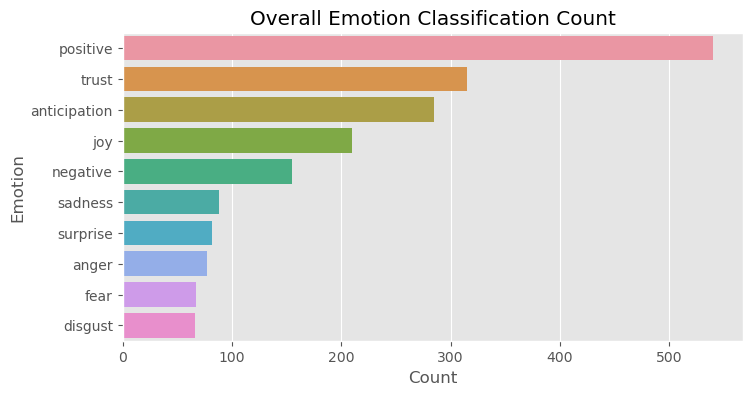

In [284]:
def chart_EmotionLex_emotionCount(df, title, x, agg):
    emotion_list = ['fear','anger','anticipation','trust','surprise','positive','negative',
                   'sadness','disgust','joy'];
    data = [];
    for emotion in emotion_list:
        row = [];
        row.append(emotion);
        if agg == "sum":
            row.append(df[emotion].sum());
        elif agg == "mean":
            row.append(df[emotion].mean());
        data.append(row);
    df_emotionCount = pd.DataFrame(data, columns=['Emotion',x]);
    df_emotionCount = df_emotionCount.sort_values(by=x, ascending=False);
    
    fig, ax = plt.subplots(figsize=(8,4));
    ax = sns.barplot(data=df_emotionCount, x=x, y='Emotion');
    ax.set(title=title);
    return ax;

chart_EmotionLex_emotionCount(
    df=df_with_emotionLex_emotionCount,
    title='Overall Emotion Classification Count',
    x='Count',
    agg="sum"
)

/var/folders/6l/mm7mjc7502v12t9w6jsrkdcr0000gn/T/ipykernel_20179/3192628330.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=xticklabels, title=title);


<AxesSubplot:title={'center':'Emotion Classification Count over the years'}, xlabel='Year', ylabel='Count'>

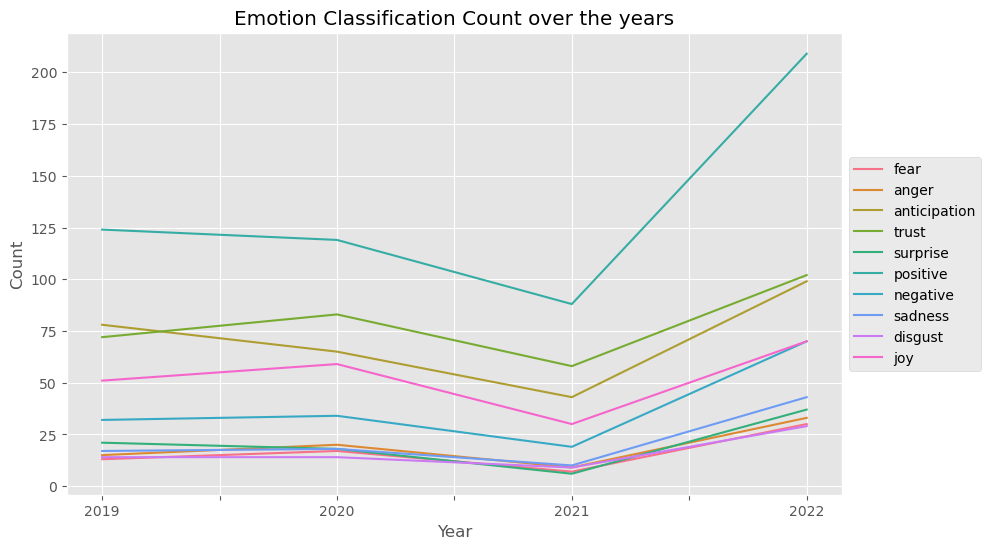

In [266]:
def chart_EmotionLex_emotionCount_byType(df, column, labels, xticklabels, title):
    emotion_list = ['fear','anger','anticipation','trust','surprise','positive','negative',
                   'sadness','disgust','joy'];
    column_list = df[column].unique().tolist();
    column_list = column_list[::-1];
    
#     data = [];
#     for emotion in emotion_list:
#         row = [];
#         row.append(emotion);
#         for col in column_list:
#             row.append(df[df[column] == col][emotion].sum());
#         data.append(row);
#     labels = ['Emotion'];
#     for col in column_list:
#         labels.append(col);
#     df_emotionCountType = pd.DataFrame(data, columns=labels);
#     display(df_emotionCountType);
    
    data = [];
    for emotion in emotion_list:
        for col in column_list:
            row = [];
            row.append(emotion);
            row.append(col);
            row.append(df[df[column] == col][emotion].sum());
            data.append(row);
    df_emotionCountType = pd.DataFrame(data, columns=labels);
    
    fig, ax = plt.subplots(figsize=(10,6));
    ax = sns.lineplot(data=df_emotionCountType, x="Year", y="Count", hue="Emotion");
    ax.set(xticklabels=xticklabels, title=title);
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    return ax;

chart_EmotionLex_emotionCount_byType(
    df=df_with_emotionLex_emotionCount, 
    column='Year of Review',
    labels=['Emotion','Year','Count'],
    xticklabels=['','2019','','2020','','2021','','2022'],
    title="Emotion Classification Count over the years"
)

/var/folders/6l/mm7mjc7502v12t9w6jsrkdcr0000gn/T/ipykernel_20179/2007818757.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set(xticklabels=xticklabels, title=emotion_list[i]);
/var/folders/6l/mm7mjc7502v12t9w6jsrkdcr0000gn/T/ipykernel_20179/2007818757.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set(xticklabels=xticklabels, title=emotion_list[i]);
/var/folders/6l/mm7mjc7502v12t9w6jsrkdcr0000gn/T/ipykernel_20179/2007818757.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set(xticklabels=xticklabels, title=emotion_list[i]);
/var/folders/6l/mm7mjc7502v12t9w6jsrkdcr0000gn/T/ipykernel_20179/2007818757.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set(xticklabels=xticklabels, title=emotion_list[i]);
/var/folders/6l/mm7mjc7502v12t9w6jsrkdcr0000gn/T/ipykernel_20179/2007818757.py:29: UserWarning: FixedFormatter should only b

array([<AxesSubplot:title={'center':'fear'}, xlabel='Year', ylabel='Count'>,
       <AxesSubplot:title={'center':'anger'}, xlabel='Year', ylabel='Count'>,
       <AxesSubplot:title={'center':'anticipation'}, xlabel='Year', ylabel='Count'>,
       <AxesSubplot:title={'center':'trust'}, xlabel='Year', ylabel='Count'>,
       <AxesSubplot:title={'center':'surprise'}, xlabel='Year', ylabel='Count'>,
       <AxesSubplot:title={'center':'positive'}, xlabel='Year', ylabel='Count'>,
       <AxesSubplot:title={'center':'negative'}, xlabel='Year', ylabel='Count'>,
       <AxesSubplot:title={'center':'sadness'}, xlabel='Year', ylabel='Count'>,
       <AxesSubplot:title={'center':'disgust'}, xlabel='Year', ylabel='Count'>,
       <AxesSubplot:title={'center':'joy'}, xlabel='Year', ylabel='Count'>],
      dtype=object)

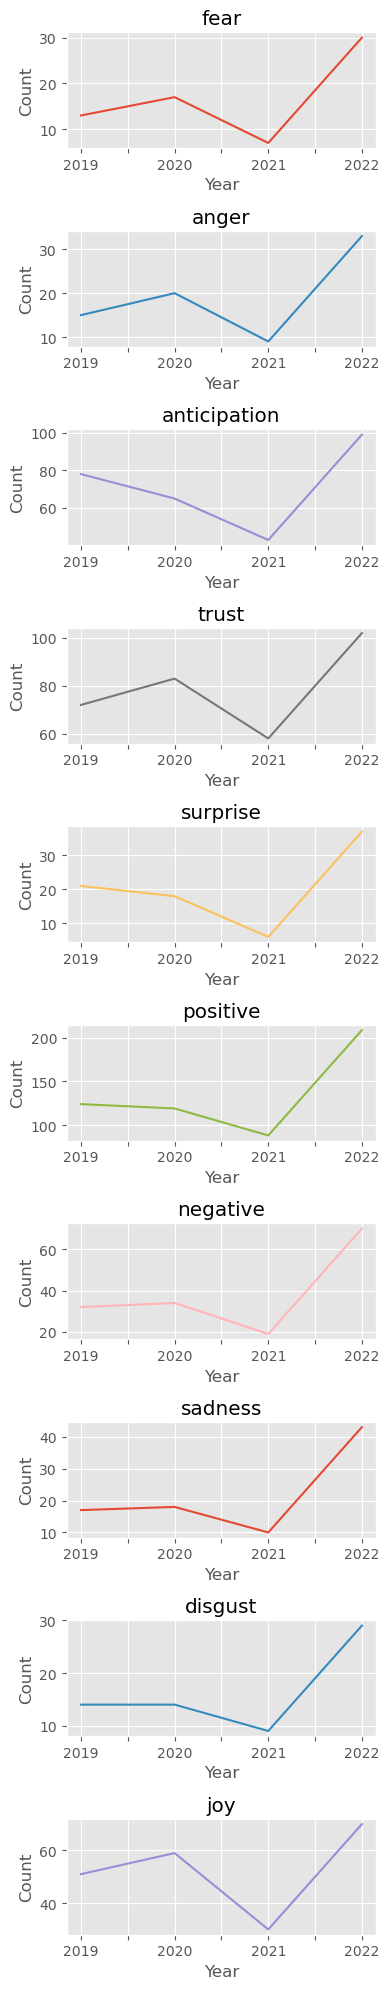

In [256]:
def chart_EmotionLex_emotionCount_byType_Compare(df, column, labels, xticklabels):
    emotion_list = ['fear','anger','anticipation','trust','surprise','positive','negative',
                   'sadness','disgust','joy'];
    column_list = df[column].unique().tolist();
    column_list = column_list[::-1];
    
    data = [];
    for emotion in emotion_list:
        for col in column_list:
            row = [];
            row.append(emotion);
            row.append(col);
            row.append(df[df[column] == col][emotion].sum());
            data.append(row);
    df_emotionCountType = pd.DataFrame(data, columns=labels);
    
    fig, ax = plt.subplots(10, 1, figsize=(4,20));
    palette = itertools.cycle(sns.color_palette())
    for i in range(len(emotion_list)):
        c = next(palette);
        sns.lineplot(
            ax=ax[i],
            data=df_emotionCountType[df_emotionCountType['Emotion'] == emotion_list[i]],
            x="Year", 
            y="Count",
            color=c
        );
        ax[i].set(xticklabels=xticklabels, title=emotion_list[i]);
        plt.tight_layout();
    return ax;

chart_EmotionLex_emotionCount_byType_Compare(
    df=df_with_emotionLex_emotionCount, 
    column='Year of Review', 
    labels=['Emotion','Year','Count'],
    xticklabels=['','2019','','2020','','2021','','2022'],
)



In [161]:
df_with_emotionLex_affectFreq = get_emotionCount_EmotionLex(
    df=df, 
    column='Review Cleaned',
    metric='affect_frequencies'
);
df_with_emotionLex_affectFreq.head(2)

  0%|          | 0/324 [00:00<?, ?it/s]

,Reviewer Name,Reviewer Title,Total Reviews Given,Review,Stars Given,Year of Review,Time of Review,Webscraping Datetime,Review Cleaned,fear,anger,anticipation,trust,surprise,positive,negative,sadness,disgust,joy
0,Alex Reyes,No Title,2,No Review,3,2022,a month ago,2023-01-29 20:55:10,review,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00
1,Hugo Nakamura,Local Guide,25,"EDIT: The second time coming to the store, the...",5,2022,a month ago,2023-01-29 20:55:10,edit second time coming store employee kind he...,0.0,0.0,0.25,0.166667,0.0,0.333333,0.0,0.0,0.0,0.25


<AxesSubplot:title={'center':'Average Emotion Classification Frequency'}, xlabel='Frequency', ylabel='Emotion'>

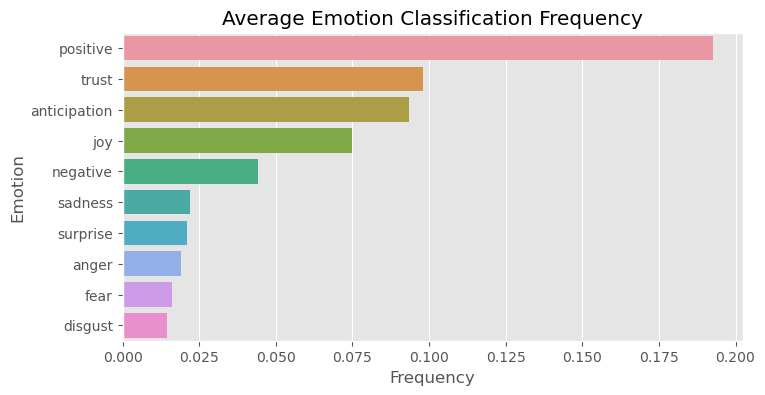

In [286]:
chart_EmotionLex_emotionCount(
    df=df_with_emotionLex_affectFreq,
    title='Average Emotion Classification Frequency',
    x='Frequency',
    agg="mean"
)